In [1]:
import geopandas as gpd
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.uk import UniversalKriging
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import random


In [2]:
ds = xr.open_dataset('C:/Users/Acer/Documents/SchoolHard/Thesis/Code/dataset//chl_merged_2002_08_2022_10.nc')

In [4]:
ds

<xarray.Dataset>
Dimensions:  (time: 243, lat: 51, lon: 33, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 7.729 7.687 7.646 7.604 ... 5.771 5.729 5.687 5.646
  * lon      (lon) float32 125.2 125.2 125.3 125.3 ... 126.4 126.4 126.5 126.5
  * time     (time) datetime64[ns] 2002-08-01 2002-09-01 ... 2022-10-01
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a  (time, lat, lon) float32 ...
    palette  (time, rgb, eightbitcolor) uint8 ...
Attributes: (12/62)
    product_name:                     AQUA_MODIS.20020801_20020831.L3m.MO.CHL...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    source:                           satellite observations from MODIS-Aqua
    ...                               ...
    cdm_data_type:                    grid
    keywords:                         Earth Science > Oceans > Ocean Chemistr...
    keywords_vocabulary:              NASA Global Change Master Directory (GC...
    data_bins:                        17371971
    data_minimum:                     0.0031615312
    data_maximum:                     86.2636

In [3]:
#define time steps, 243 monthly observations
start_date = pd.Timestamp('2002-08-01')
end_date = pd.Timestamp('2022-10-01')

#Create a new time coordinate that represents the month and year
time_coords = pd.date_range(start=start_date, end=end_date, freq='MS')

In [4]:
n = 24
samples = random.sample(list(time_coords), n)

In [5]:
#Define the number of folds for cross validation
n_splits = 3

In [6]:
#Create a KFold object to split the data
kf = KFold(n_splits=n_splits)

In [7]:
#metrics list
mse_list = []
rmse_list = []
mae_list = []
residual_list = np.array([])
interp_list = np.array([])

set: 0


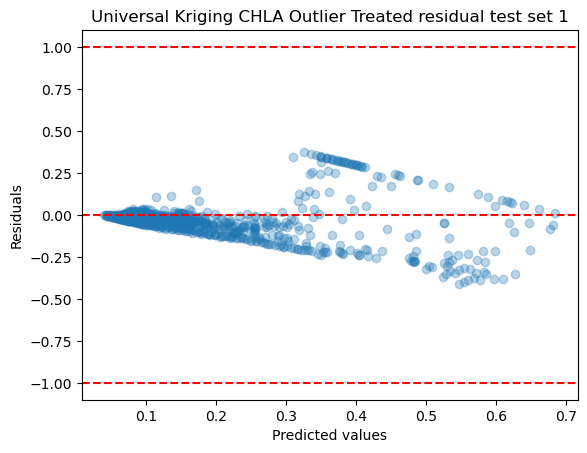

set: 1


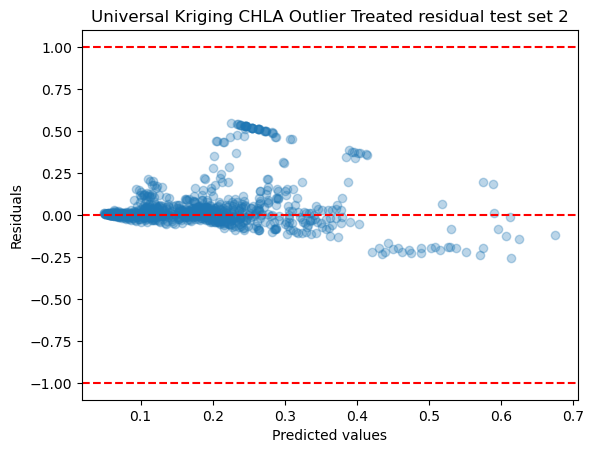

set: 2


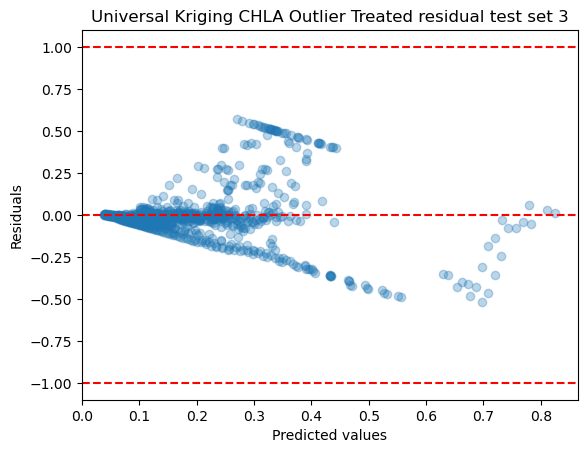

set: 3


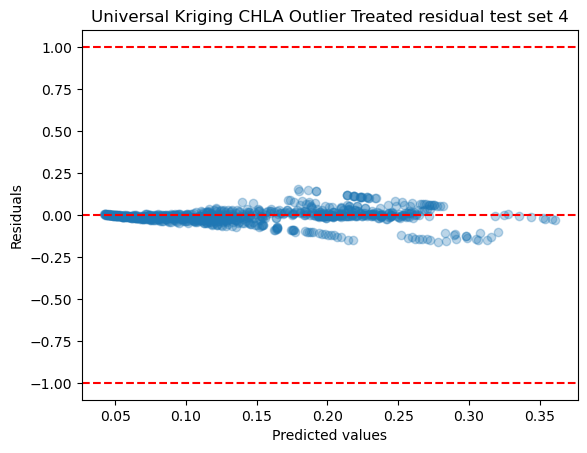

set: 4


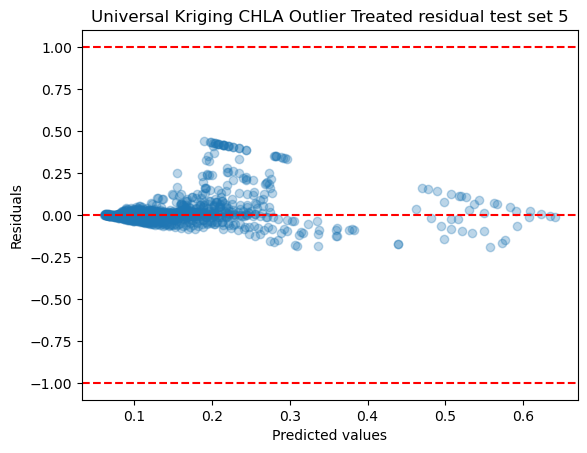

set: 5


KeyboardInterrupt: 

In [8]:
for t in range(len(samples)):
    
    print('set: ' + str(t))
    
    monthly_data = ds['chlor_a'].sel(time= samples[t])
    lon = monthly_data['lon'].values
    lat = monthly_data['lat'].values
    
    #Convert the dataset to a pandas dataframe
    df = monthly_data.to_dataframe().reset_index()
    
    #convert dataframe to geodataframe 
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
    
    #SET CRS to WGS84
    gdf.crs = 'WGS84'
    
    #dropna in gdf
    gdf = gdf.dropna()
    
    # Convert the GeoDataFrame to a DataFrame
    df_if = pd.DataFrame(gdf[["lat", "lon", "chlor_a"]])

    # Compute the Isolation Forest score for each data point
    clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1, random_state=42)
    clf.fit(df_if[["chlor_a"]])
    scores = clf.score_samples(df_if[["chlor_a"]])
    df_if["score"] = scores

    # Use the scores to detect outliers
    threshold = np.percentile(scores, 10)
    df_if["outlier"] = np.where(scores < threshold, -1, 1)

    # Treat outliers by replacing them with the median of the surrounding data, with a maximum of 2
    df_if.loc[df_if["outlier"] == -1, "chlor_a"] = np.clip(df_if["chlor_a"].rolling(10, center=True).median().fillna(method='bfill').fillna(method='ffill'), None, 1)

    # Drop the intermediate columns
    df_if.drop(columns=["score", "outlier"], inplace=True)

    # Convert the DataFrame back to a GeoDataFrame
    gdf["chlor_a"] = df_if["chlor_a"]
    
    #Get x, y, z values - this is the lon, lat, and variable/sst
    x = gdf.geometry.x
    y = gdf.geometry.y
    z = gdf['chlor_a']
    
    x_grid = np.linspace(lon.min(), lon.max(), num=100)
    y_grid = np.linspace(lat.min(), lat.max(), num=100)
    XI, YI = np.meshgrid(x_grid, y_grid)
    
    for train_index, test_index in kf.split(gdf):
        #Train and Test splits
        train_gdf = gdf.iloc[train_index].reset_index()
        test_gdf = gdf.iloc[test_index].reset_index()

        #Train data x,y,z
        x_train = train_gdf.geometry.x
        y_train = train_gdf.geometry.y
        z_train = train_gdf['chlor_a']

        #Ordinary Kriging
        unkrig = UniversalKriging(x_train, y_train, z_train, variogram_model="linear", verbose=False, enable_plotting=False)
    
        #Train data x,y,z
        x_test = test_gdf.geometry.x
        y_test = test_gdf.geometry.y
        z_test = test_gdf['chlor_a']

        ZI_test = np.zeros_like(x_test)
        for i in range(len(x_test)):
            ZI_test[i], sigma = unkrig.execute("grid", x_test[i], y_test[i])
        
        #Calculate residuals
        residuals = z_test - ZI_test
        
        residual_list = np.append(residual_list, residuals)
        interp_list = np.append(interp_list, ZI_test)
        
        #MSE -mean squared error
        mse = mean_squared_error(z_test, ZI_test)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(z_test, ZI_test)
    
        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)
   
    plt.scatter(interp_list, residual_list, alpha= 0.3)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.axhline(y=1, color='red', linestyle='--')
    plt.axhline(y=-1, color='red', linestyle='--')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.title('Universal Kriging CHLA Outlier Treated residual test set ' + str(t + 1))
    plt.show()
    plt.close()
    residual_list = []
    interp_list = []
    

In [ ]:
# Compute the mean  of MSE MAE RMSE across all folds
mean_mse = np.mean(mse_list)
std_mse = np.std(mse_list)

mean_rmse = np.mean(rmse_list)
std_rmse = np.std(rmse_list)

mean_mae = np.mean(mae_list)
std_mae = np.std(mae_list)

print('MSE:  ' + str(mean_mse))
print('RMSE:  ' + str(mean_rmse))
print('MAE:  ' + str(mean_mae))